In [1]:
"""
Preparation of reference data for 
"""

import os, sys
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import gc

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# Load the environment variables

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'

# Coordinate Ref. System
utm18n = 32618  # UTM Zone 18N (Washington, D.C.)

print("Ready !")

Ready !


In [2]:
gdf_fp = os.path.join(maindir, 'data/spatial/raw/dc_data/training/dc_data_ocm_w_ztrax_matched.gpkg')
gdf = gpd.read_file(gdf_fp).to_crs(utm18n)
print(f'Length of DC data: {len(gdf)};')

Length of DC data: 158241;


In [3]:
gdf.RoofCoverStndCode.unique()

array(['CS', 'ME', 'BU', 'SL', '', 'UR', 'TL', 'WS', 'SH', 'OT', 'WD',
       'CN'], dtype=object)

In [4]:
# add the class code categorical variable
gdf.loc[:, 'class_code'] = gdf['RoofCoverStndCode'].astype('category')
print(list(gdf['class_code'].unique()))

['CS', 'ME', 'BU', 'SL', '', 'UR', 'TL', 'WS', 'SH', 'OT', 'WD', 'CN']


In [5]:
# Drop footprints with no roof material information
gdf = gdf[gdf['class_code'] != '']
gdf.class_code.value_counts()

class_code
CS    37133
ME    36864
BU    36830
SL    15267
UR     1279
WS     1152
TL      924
SH      783
OT       14
WD        9
CN        4
          0
Name: count, dtype: int64

In [6]:
# Remove footprints with no roof material code

In [7]:
# Create the area attribute and filter mismatches
gdf['areaUTM'] = [geom.area for geom in gdf.geometry]
gdf['areaUTMsqft'] = [geom.area * 10.7639 for geom in gdf.geometry]
# Calculate the percent difference between the area and reported lot size
gdf['areaPctDiff'] = (gdf['areaUTMsqft'] - gdf['LotSizeSquareFeet']).abs() / gdf['LotSizeSquareFeet'] * 100

# filter the footprints by distance metric (output from fuzzy join) and percent difference
gdf_ = gdf.loc[(gdf._distance <= 20) & (gdf.areaUTMsqft <= gdf.LotSizeSquareFeet)]
len(gdf_)

125590

In [8]:
gdf_.class_code.value_counts()

class_code
CS    36134
ME    35355
BU    35191
SL    14931
UR     1190
WS     1109
TL      897
SH      757
OT       13
WD        9
CN        4
          0
Name: count, dtype: int64

In [9]:
# Handle 'bad' classes
bad_classes = ['','BU','OT'] # empty, "Built Up", "other"

out_gdfs = []
for cl in gdf.class_code.unique():

    if cl in bad_classes:
        continue

    _gdf = gdf.loc[gdf.class_code == cl]

    # skip small sample size
    if _gdf.shape[0] < 10:
        print(f'Class {cl} has shape {_gdf.shape} ... skipping ...')
        continue

    out_gdfs.append(_gdf)

# Concatenate the reference data
ref = pd.concat(out_gdfs)
print(ref['class_code'].value_counts())

del out_gdfs, _gdf
gc.collect()

Class WD has shape (9, 87) ... skipping ...
Class CN has shape (4, 87) ... skipping ...
class_code
CS    37133
ME    36864
SL    15267
UR     1279
WS     1152
TL      924
SH      783
          0
BU        0
CN        0
OT        0
WD        0
Name: count, dtype: int64


0

In [10]:
# Load the class code lookup table
lookup = pd.read_csv(os.path.join(maindir,'data/tabular/raw/variable_lookup/RoofCoverStndCode_encoding.csv'))
lookup.head(25)

,Code,Description,numcode
0,AL,Aluminum,1
1,AP,Asphalt,2
2,AS,Asbestos,3
3,BR,Bermuda,4
4,BU,Built Up,5
5,CN,Concrete,6
6,CS,Composition Shingle,7
7,FG,Fiberglass,8
8,GR,Gravel/rock,9
9,GY,Gypsum,10


In [11]:
# Create a unique ID column
ref['uid'] = ref.index + 1
ref['uid'] = ref['uid'].astype(str) + ref['class_code'].astype(str)

# Join to the lookup table to get the description
lookup = lookup[['Description','Code']]
lookup = lookup.rename(columns={"Code": "class_code","Description": "description"})
ref = ref.merge(lookup, on='class_code')

# Select the required columns
ref = ref[['uid', 'class_code', 'description', 'areaUTMsqft', 'LotSizeSquareFeet', 'geometry']]
ref = ref.rename(columns={"LotSizeSquareFeet": "lotSizeSqft"})
ref.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,geometry
0,1CS,CS,Composition Shingle,357.783709,5574.0,"POLYGON ((324215.868 4313568.665, 324215.792 4..."
1,3CS,CS,Composition Shingle,918.640862,1111.0,"POLYGON ((324602.816 4311717.247, 324604.322 4..."
2,9CS,CS,Composition Shingle,1383.414170,4222.0,"POLYGON ((327253.581 4300371.859, 327258.154 4..."
3,19CS,CS,Composition Shingle,836.410297,3450.0,"POLYGON ((333608.13 4306267.691, 333607.957 43..."
4,27CS,CS,Composition Shingle,330.514264,4352.0,"POLYGON ((326482.699 4300939.466, 326487.386 4..."


In [12]:
desc_mapping = dict(zip(ref['class_code'], ref['description']))
print(f'Description map: \n{desc_mapping}')

Description map: 
{'CS': 'Composition Shingle', 'ME': 'Metal', 'SL': 'Slate', 'UR': 'Urethane', 'TL': 'Tile', 'WS': 'Wood shake/shingle', 'SH': 'Shingle'}


In [13]:
# Summary statistics for footprint area

In [14]:
# Calculate the longest side length of the building
area_stats = ref.groupby('class_code', observed=True).apply(footprint_area_stats, include_groups=False).reset_index()
area_stats

,class_code,mean_area,pct90_area,mean_side_length,std_side_length,max_side_length,pct90_longest_side
0,CS,95.621199,166.170111,9.831502,2.272719,173.028616,17.755743
1,ME,82.708315,116.700040,10.022152,4.143337,125.457656,19.884409
2,SH,104.689081,182.132193,10.569374,2.764374,57.381896,19.021785
3,SL,107.886703,184.171685,10.648820,2.019980,125.562193,19.044170
4,TL,126.227111,222.335272,11.506220,2.410722,118.610064,20.643446
5,UR,87.148012,117.249577,10.512395,4.642613,74.499673,20.765876
6,WS,109.261167,212.276398,10.588381,2.205178,47.657608,19.009579


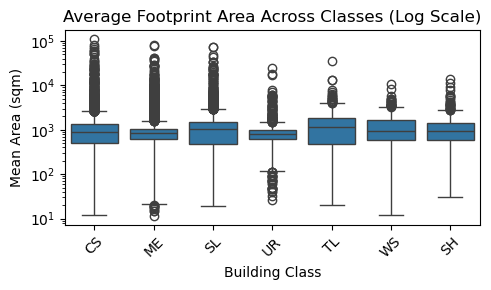

In [15]:
# Box plot for mean footprint area across classes
plt.figure(figsize=(5, 3))
sns.boxplot(x='class_code', y='areaUTMsqft', data=ref)
# Set the y-axis to log scale
plt.yscale('log')
plt.title('Average Footprint Area Across Classes (Log Scale)')
plt.ylabel('Mean Area (sqm)')
plt.xlabel('Building Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# Map of reference data

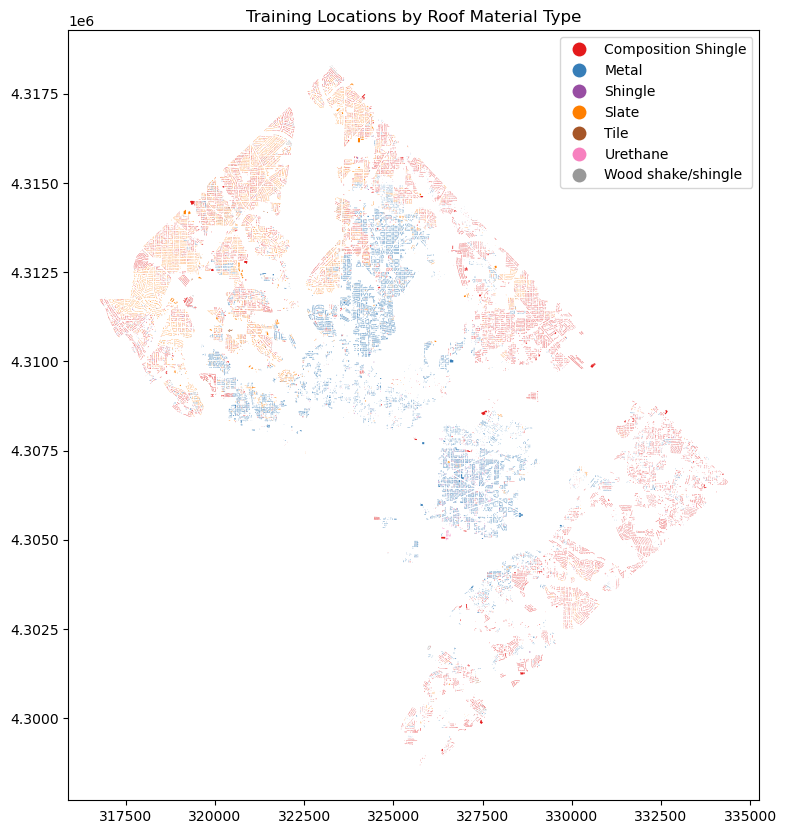

In [19]:
# Plot the training locations with colors based on roof type
fig, ax = plt.subplots(figsize=(10, 10))
ref.plot(column='description', ax=ax, legend=True, cmap='Set1')
plt.title('Training Locations by Roof Material Type')
plt.show()

In [22]:
# Save to geopackage
ref.to_file(os.path.join(maindir,'data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg'))

In [21]:
gc.collect()

80